In [23]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import calendar
from scipy.interpolate import spline

In [2]:
source="D:\\data analytics\\S2\\Ml lab\\dataset\\energy prediction\\"
solution="D:\\data analytics\\S2\\Ml lab\\dataset\\energy prediction\\GEFCOM2012_Data\\Load\\"
train_load="D:\\data analytics\\S2\\Ml lab\\dataset\\energy prediction\\Load_history.csv"
train_temp="D:\\data analytics\\S2\\Ml lab\\dataset\\energy prediction\\temperature_history.csv"
test_val="D:\\data analytics\\S2\\Ml lab\\dataset\\energy prediction\\test.csv"
test_weights="D:\\data analytics\\S2\\Ml lab\\dataset\\energy prediction\\weights.csv"
holiday="D:\\data analytics\\S2\\Ml lab\\dataset\\energy prediction\\GEFCOM2012_Data\\Load\\Holiday_List.csv"
load_soln="D:\\data analytics\\S2\\Ml lab\\dataset\\energy prediction\\GEFCOM2012_Data\\Load\\Load_solution.csv"
temp_soln="D:\\data analytics\\S2\\Ml lab\\dataset\\energy prediction\\GEFCOM2012_Data\\Load\\temperature_solution.csv"
benchmark="D:\\data analytics\\S2\\Ml lab\\dataset\\energy prediction\\GEFCOM2012_Data\\Load\\Load_benchmark.csv"

# Pre-processing

In [3]:
sln_df=pd.read_csv(load_soln)

In [4]:
bm_df=pd.read_csv(benchmark)
load_df=pd.read_csv(train_load)
temp_df=pd.read_csv(train_temp)

In [5]:
print(load_df.shape)

(33000, 28)


In [6]:
#add consolidated date column by combining year , month and day
weekdays=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
load_df['date']=load_df.apply(lambda row: str(row['year'])+"-"+str(row['month']).zfill(2)+"-"+str(row['day']).zfill(2),axis=1)
days=load_df.apply(lambda row: datetime.date(row['year'], row['month'], row['day']).strftime("%A"),axis=1)
# cat=pd.Categorical(days,categories=weekdays,ordered=True)
# load_df['day name']=cat
load_df['day name']=days
load_df.head()

,zone_id,year,month,day,h1,h2,h3,h4,h5,h6,...,h17,h18,h19,h20,h21,h22,h23,h24,date,day name
0,1,2004,1,1,"16,853","16,450","16,517","16,873","17,064","17,727",...,"14,130","16,809","18,150","18,235","17,925","16,904","16,162","14,750",2004-01-01,Thursday
1,1,2004,1,2,"14,155","14,038","14,019","14,489","14,920","16,072",...,"15,839","17,727","18,895","18,650","18,443","17,580","16,467","15,258",2004-01-02,Friday
2,1,2004,1,3,"14,439","14,272","14,109","14,081","14,775","15,491",...,"13,826","15,825","16,996","16,394","15,406","14,278","13,315","12,424",2004-01-03,Saturday
3,1,2004,1,4,"11,273","10,415","9,943","9,859","9,881","10,248",...,"14,162","16,237","17,430","17,218","16,633","15,238","13,580","11,727",2004-01-04,Sunday
4,1,2004,1,5,"10,750","10,321","10,107","10,065","10,419","12,101",...,"15,501","17,307","18,786","19,089","19,192","18,416","17,006","16,018",2004-01-05,Monday


In [7]:
def get_score_from_sum(x):
    return round(math.sqrt(x))

def get_scores(test_df):
    weight_array=np.array(sln_df['weight'])
    diff_dict={}
    for i in range (1,25):
        hour="h"+str(i)
        sln_array=np.float_(list(sln_df[hour]))
        test_array=np.float_(list(test_df[hour]))
        #(act-model)^2
        diff_square=np.square(sln_array-test_array)
        diff_dict[hour]=diff_square
    diff_df=pd.DataFrame.from_dict(diff_dict)
    diff_df['weight']=sln_df['weight']
    
    #get backcast diff (backcast weight are 1 and 20)
    backcast_df=diff_df[(diff_df['weight']==1) | (diff_df['weight']==20)]
    #sum of backcast weights (multiply by 24 because each row has 24 values)
    bc_sum_weights=backcast_df['weight'].sum() * 24   
    #get wi/sum(wi) for each backcast weight wi
    bc_weight_array=np.true_divide(np.array(backcast_df['weight']),bc_sum_weights)
    
    #get forecast weight array and sum of weights
    forecast_df=diff_df[(diff_df['weight']==8) | (diff_df['weight']==160)]
    fc_sum_weights=forecast_df['weight'].sum() * 24   
    fc_weight_array=np.true_divide(np.array(forecast_df['weight']),fc_sum_weights)
    
    #get total weight array and sum of weights
    tot_sum_weights=sln_df['weight'].sum()*24
    tot_weight_array=np.true_divide(np.array(sln_df['weight']),tot_sum_weights)
    
    fc_sum=0.0
    bc_sum=0.0
    tot_sum=0.0
    for i in range(1,25):
        hour="h"+str(i)
        #find (wi/sum(wi)) * sum((act-obtained)^2) for each hour
        bc_weighed_array=np.array(backcast_df[hour])*bc_weight_array
        fc_weighed_array=np.array(forecast_df[hour])*fc_weight_array
        tot_weighed_array=np.array(diff_df[hour])*tot_weight_array
        bc_sum +=bc_weighed_array.sum()
        fc_sum +=fc_weighed_array.sum()
        tot_sum +=tot_weighed_array.sum()
    bc_score=get_score_from_sum(bc_sum)
    fc_score=get_score_from_sum(fc_sum)
    tot_score=get_score_from_sum(tot_sum)    
    return bc_score,fc_score,tot_score
#find scores of benchmark
bm_scores=get_scores(bm_df)
print(bm_scores)

(69557, 123758, 100385)


In [8]:
rows_with_nan=load_df[load_df.isnull().any(axis=1)]
print("size of rows with nan : ",rows_with_nan.shape)
days_with_nan=set(list(rows_with_nan['date']))
print(days_with_nan)


size of rows with nan :  (1280, 30)
{'2005-09-11', '2005-09-10', '2008-07-05', '2008-07-04', '2005-09-12', '2005-12-30', '2005-12-31', '2006-08-02', '2006-08-07', '2005-03-12', '2005-06-22', '2006-02-15', '2005-03-07', '2005-06-21', '2006-08-05', '2006-11-28', '2005-06-23', '2005-09-16', '2005-03-06', '2008-07-01', '2005-12-29', '2006-05-27', '2006-02-13', '2008-06-30', '2006-02-14', '2005-09-13', '2005-12-25', '2005-03-11', '2006-05-29', '2006-05-25', '2005-12-27', '2005-12-28', '2006-02-18', '2006-11-23', '2006-05-28', '2006-08-04', '2005-06-20', '2006-05-30', '2006-11-24', '2006-11-22', '2006-11-27', '2005-09-15', '2006-05-31', '2005-12-26', '2005-06-26', '2008-07-06', '2006-11-25', '2008-07-02', '2008-07-07', '2005-06-24', '2005-03-09', '2006-02-17', '2006-02-19', '2005-03-08', '2006-08-03', '2006-11-26', '2006-02-16', '2008-07-03', '2005-06-25', '2006-08-08', '2005-03-10', '2006-05-26', '2006-08-06', '2005-09-14'}


In [9]:
partial_data_rows=rows_with_nan[rows_with_nan.filter(regex='h[0-9]+',axis=1).notnull().any(1)]
print(set(list(partial_data_rows['date'])))

{'2008-06-30'}


Found days with nan values
These are the values that should be predicted by model

In [10]:
#get non null rows
train_df=load_df[~load_df.isnull().any(axis=1)]
#convert values to numeric
hours=["h"+str(hour) for hour in range(1,25)]
for col in hours:
    train_df[col]=train_df[col].apply(lambda x:x.replace(",",""))
    train_df[col]=pd.to_numeric(train_df[col])


C:\Users\dell\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\dell\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [11]:
# train_df['total']=train_df.apply(lambda row: row[hours].sum()/1000000,axis=1)
# train_df.head()
# train_df[hours].sum(axis=1)/1000000
train_df['total']=train_df[hours].sum(axis=1)/1000000

C:\Users\dell\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


C:\Users\dell\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
C:\Users\dell\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


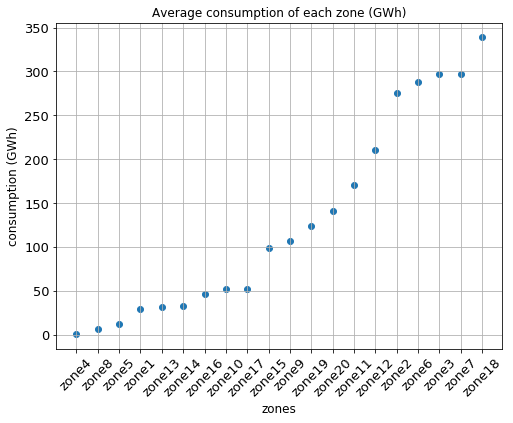

In [12]:
#average of each zones
zone_avg_dict={}
for zone in range(1,21):
    zone_df=train_df[(train_df['zone_id']==zone)]
    zone_df=zone_df[hours]
    #get sum of hourly loads in kW
    sum_list=np.array(zone_df.sum(axis = 0, skipna = True))
    #total sum
    sum=np.sum(sum_list)
    #divide by 10^6*24 to get gWh value
    sum_gwh=sum/(math.pow(10,6)*24)
    zone_avg_dict["zone"+str(zone)]=sum_gwh
# plt.plot(range(1,21),zone_avg.values(), 'ro')
# plt.xticks(range(len(zone_avg)), list(zone_avg.keys()), rotation=45)
# plt.show()
plt.figure(figsize=(8, 6))
lists = sorted(zone_avg_dict.items(), key=lambda kv: kv[1]) # sorted by key, return a list of tuples
x, y = zip(*lists) # unpack a list of pairs into two tuples
plt.title("Average consumption of each zone (GWh)")
plt.xlabel("zones",fontsize=12)
plt.ylabel("consumption (GWh)",fontsize=12)
plt.scatter(x,y)
plt.tick_params(axis='both', which='major', labelsize=13)
plt.xticks(rotation=45)
plt.axes().xaxis.grid()
plt.axes().yaxis.grid()
plt.show()

In [33]:

# for day in weekdays:
#     day_df=train_df[train_df['day name']==day]
agg_df=train_df.groupby(['year','month','day','date','day name']).sum().reset_index()
agg_df=agg_df.drop(['zone_id'],axis=1)

In [34]:
print(agg_df.shape)

(1586, 30)


Text(0,0.5,'Toal (GW)')

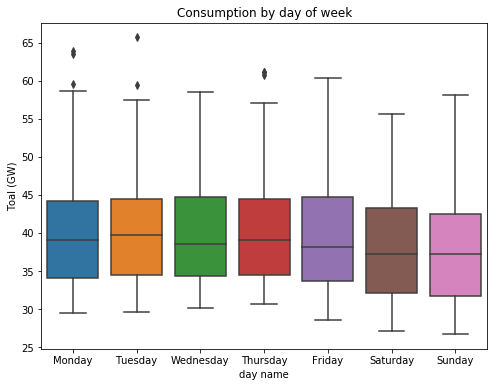

In [35]:
plt.figure(figsize=(8, 6))
plt.title("Consumption by day of week")
sns.boxplot(x='day name',y='total',data=agg_df,order=weekdays)
plt.ylabel("Toal (GW)")

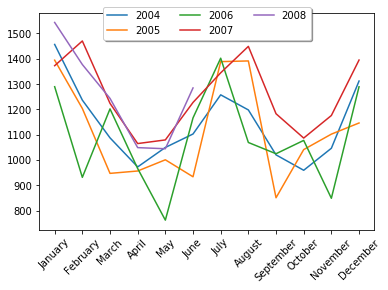

In [36]:
months= [calendar.month_name[i] for i in range (1,13)]
month_agg_df=month_agg_df=train_df.groupby(['year','month']).sum()
month_agg_df=month_agg_df.reset_index()
for year in month_agg_df['year'].unique():
    sub_df=month_agg_df[month_agg_df['year']==year]
    plt.plot(list(sub_df['month']),list(sub_df['total']),label=year)
    plt.xticks(range(1,13),months,rotation=45)
# plt.legend(loc='upper left')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)
plt.show()

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24]), <a list of 24 Text xticklabel objects>)

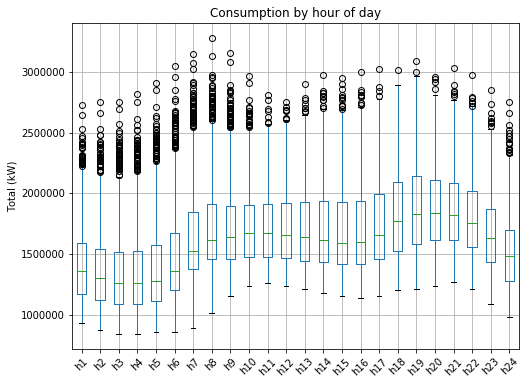

In [40]:
plt.figure(figsize=(8, 6))
plt.title("Consumption by hour of day")
# sns.boxplot(x='day name',y='total',data=agg_df,order=weekdays)
agg_df.boxplot(column=hours)
plt.ylabel("Total (kW)")
plt.xticks(rotation=45)

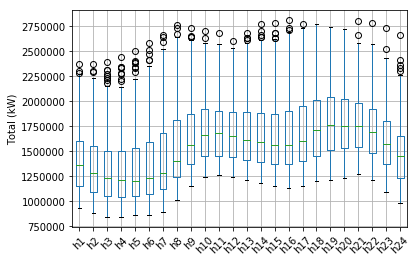

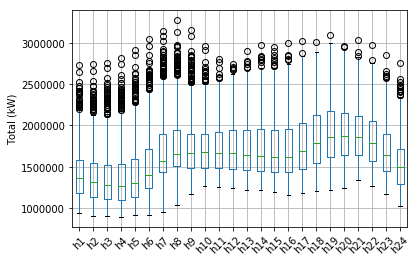

In [48]:
#split by week days
agg_df_weekends=agg_df[(agg_df['day name']=='Sunday') | (agg_df['day name']=='Saturday')]
agg_df_weekdays=agg_df[(agg_df['day name']!='Sunday') & (agg_df['day name']!='Saturday')]
# plt.title("Consumption by hour of day in weekends")
agg_df_weekends.boxplot(column=hours)
plt.ylabel("Total (kW)")
plt.xticks(rotation=45)
# plt.title("Consumption by hour of day in week days")
plt.show()
agg_df_weekdays.boxplot(column=hours)
plt.ylabel("Total (kW)")
plt.xticks(rotation=45)
plt.show()